In [ ]:
!pip install torchmetrics
!pip install av
!pip install ffmpeg

In [ ]:
!rm -r sample_data/
!mkdir data_samples/
!mkdir data_samples/clips_cropped
!mkdir checkpoints/

In [ ]:
# Metadata and implementation
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/model.py -O model.py
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/evaluator.py -O evaluator.py
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/dataloader.py -O dataloader.py
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/data_samples/multiclass_descriptions.json -O multiclass_descriptions.json
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/HowToChange/annotation/train.csv -O data_samples/train.csv
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/HowToChange/annotation/test.csv -O data_samples/test.csv


In [ ]:
# video data
!wget https://utexas.box.com/shared/static/dsmzxn48gvibzvprvmoewcdo8ddq9va9.zip -O clips_cropped.zip
!unzip clips_cropped.zip
!mv clips_cropped/* data_samples/clips_cropped
!rmdir clips_cropped

In [ ]:
from cgi import print_form
import tqdm
import av
from dataloader import HowToChangeDatasetBatched, custom_collate
import torch
from model import OTSC_Model
from evaluator import Evaluator
from torch.utils.data import DataLoader
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def run_video(model, batch_data, device, descriptions_dict):
    frames_all = batch_data["frames"].float().to(device)
    labels_all = batch_data["labels"].to(device)
    lengths = batch_data["lengths"].to(device)
    osc_names = batch_data["osc"]
    fps = batch_data["fps"][0]
    duration = batch_data["durations"]

    B, Max_T = frames_all.shape[:2]
    Max_D = int(max(duration))
    text_flat, text_raw = model.get_text_features_batch(osc_names, descriptions_dict)

    hidden_state = None
    progress_buffer = []

    batch_preds = [[] for _ in range(B)]
    batch_gts = [[] for _ in range(B)]

    for s in range(Max_D):
        t = min(int(fps*s), Max_T)
        active_mask = (lengths > t).float().unsqueeze(1)
        if active_mask.sum() == 0: break

        current_frames = frames_all[:, t]
        current_labels = labels_all[:, t]

        logits, progress, hidden_state, img_feat = model(current_frames, text_flat, hidden_state)
        prior_logits = torch.matmul(img_feat.unsqueeze(1), text_raw.transpose(1, 2)).squeeze(1)

        current_preds = torch.argmax(logits, dim=-1).cpu().numpy()
        for i in range(B):
            if t < lengths[i]:
                batch_preds[i].append(current_preds[i])
                batch_gts[i].append(labels_all[i, t].item())
    hidden_state = hidden_state.detach()
    return batch_preds, batch_gts

In [ ]:
def load_descriptions():
    desc_path = "multiclass_descriptions.json"
    descriptions_dict = {}

    if os.path.exists(desc_path):
        with open(desc_path, "r") as f:
            descriptions_dict = json.load(f)
        print(f"Loaded {len(descriptions_dict)} descriptions.")
    else:
        print(f"NOT LOADING DESCRIPTIONS, USING DEFAULT")
    return descriptions_dict

descriptions_dict = load_descriptions()
list(descriptions_dict.keys())[0:5]

Loaded 409 descriptions.


['rolling_dough',
 'rolling_fondant',
 'rolling_pastry',
 'rolling_meatball',
 'rolling_clay']

In [ ]:
device = None
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")

using GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = HowToChangeDatasetBatched(split="test")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)
E = Evaluator(end_label=2, out_dir="results")
model = OTSC_Model()
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/cs381V-model-ckpt/final_model_ckpt6.pt"
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)
model.eval()

In [ ]:
i = 0
torch.set_printoptions(threshold=torch.inf, precision=2, sci_mode=False)
verbs = []
E.end_state_metrics = {
    'first_frame_diff': {'known': [], 'novel': []},
    'iou': {'known': [], 'novel': []},   # only for videos with non-empty end_state intervals
    'total_intersection': {'known': [], 'novel': []},   # to be aggregated over all videos
    'total_union': {'known': [], 'novel': []},   # to be aggregated over all videos
    'accuracy_2': {'known': [], 'novel': []},   # binary
    'accuracy_all': {'known': [], 'novel': []}, # ternary
    'recall': {'known': [], 'novel': []},
    'precision': {'known': [], 'novel': []},
    'f1_0': {'known': [], 'novel': []},
    'f1_1': {'known': [], 'novel': []},
    'f1_2': {'known': [], 'novel': []},
    'f1_macro': {'known': [], 'novel': []},
    'f1_micro': {'known': [], 'novel': []}
}

prev_count = 0
with torch.no_grad():
    for data in tqdm.tqdm(dataloader):
        is_novel = data["is_novel"][0]
        preds, gts = run_video(model, data, device, descriptions_dict)
        pred = torch.tensor(preds[0])
        gt = torch.tensor(gts[0])
        video_name = data["video_name"][0]
        osc = data["osc"][0]
        verb = osc.split("_")[0]
        verbs.append(verb)
        pred_bin = E.bin(pred)
        gt_bin = E.bin(gt)
        E.record_bin_metrics(pred_bin, gt_bin, is_novel)
        E.record_tern_metrics(pred, gt, is_novel)
        E.record_IoU(pred, gt, is_novel)
        E.record_framediff(pred, gt, is_novel)
        curr_count = len(E.end_state_metrics.get('first_frame_diff').get('known'))
        if curr_count > prev_count + 1:
          print(f"STOPPING AT {video_name} ({osc})")
          print("curr_count = ", curr_count)
          print("prev_count = ", prev_count)
          break
        prev_count = curr_count

        if i % 100 == 0 and i > 0:
          print("KNOWN: ", curr_count)
          print("NOVEL: ", len(E.end_state_metrics.get('first_frame_diff').get('novel')))
        i += 1
E.save_result()

 14%|█▍        | 101/712 [02:36<15:17,  1.50s/it]

KNOWN:  101
NOVEL:  0


 28%|██▊       | 201/712 [05:16<13:26,  1.58s/it]

KNOWN:  201
NOVEL:  0


 42%|████▏     | 301/712 [07:53<10:59,  1.60s/it]

KNOWN:  301
NOVEL:  0


 56%|█████▋    | 401/712 [10:38<08:22,  1.61s/it]

KNOWN:  401
NOVEL:  0


 70%|███████   | 501/712 [13:20<05:31,  1.57s/it]

KNOWN:  501
NOVEL:  0


 84%|████████▍ | 601/712 [15:56<03:26,  1.86s/it]

KNOWN:  601
NOVEL:  0


 98%|█████████▊| 701/712 [18:35<00:18,  1.69s/it]

KNOWN:  625
NOVEL:  76


100%|██████████| 712/712 [18:53<00:00,  1.59s/it]


In [ ]:
with open('verbs.txt', 'w') as file:
  file.write(str(verbs))

In [ ]:
with open('verbs.txt', 'r') as file:
  strings = file.read()[1:-1]
verbs_list = strings.replace("'", "").split(", ")
known_osc = verbs_list[:-87]
novel_osc = verbs_list[-87:]
print(f"{len(known_osc)} known, {len(novel_osc)} novel")

625 known, 87 novel


In [ ]:
with open('results/results.json', 'r') as file:
  objects = json.load(file)
print(objects.keys())
objects.get('first_frame_diff').keys()

print(len(objects.get('first_frame_diff').get('known')))  # 625
print(len(objects.get('first_frame_diff').get('novel')))  # 87

print(len(objects.get('iou').get('known'))) # 418
print(len(objects.get('iou').get('novel'))) # 61

dict_keys(['first_frame_diff', 'iou', 'total_intersection', 'total_union', 'accuracy_2', 'accuracy_all', 'recall', 'precision', 'f1_0', 'f1_1', 'f1_2', 'f1_macro', 'f1_micro'])
625
87
418
61


In [ ]:
merged_metrics = {}
merged_metrics['verb'] = verbs_list
for key in objects.keys():
  metrics = objects.get(key).get('known').copy()
  metrics.extend(objects.get(key).get('novel'))
  if len(metrics) < len(verbs_list):
    continue
  merged_metrics[key] = metrics

In [ ]:
df = pd.DataFrame(merged_metrics)
df_grouped = df.groupby(df['verb'], as_index=False).mean()

df_accuracy = df_grouped[['verb', 'accuracy_all', 'accuracy_2']].sort_values(by='accuracy_all')
df_f1 = df_grouped[['verb', 'f1_macro', 'f1_micro']].sort_values(by='f1_macro')

df_grouped.head()

,verb,first_frame_diff,total_intersection,total_union,accuracy_2,accuracy_all,recall,precision,f1_0,f1_1,f1_2,f1_macro,f1_micro
0,blending,11.461538,8.051282,20.641026,0.697044,0.512670,0.609442,0.400445,0.381945,0.534409,0.444353,0.453569,0.512670
1,browning,15.714286,3.457143,21.371429,0.604938,0.408390,0.436208,0.177659,0.255661,0.502504,0.226149,0.328105,0.408390
2,chopping,8.574257,6.227723,19.990099,0.660246,0.442096,0.695764,0.329007,0.339389,0.439935,0.404181,0.394502,0.442096
3,coating,15.210526,5.210526,21.000000,0.637719,0.490088,0.523684,0.251699,0.188057,0.602525,0.320734,0.370439,0.490088
4,crushing,11.857143,5.892857,21.535714,0.625311,0.441455,0.668640,0.309705,0.339107,0.445149,0.375759,0.386672,0.441455


<Figure size 1800x1000 with 0 Axes>

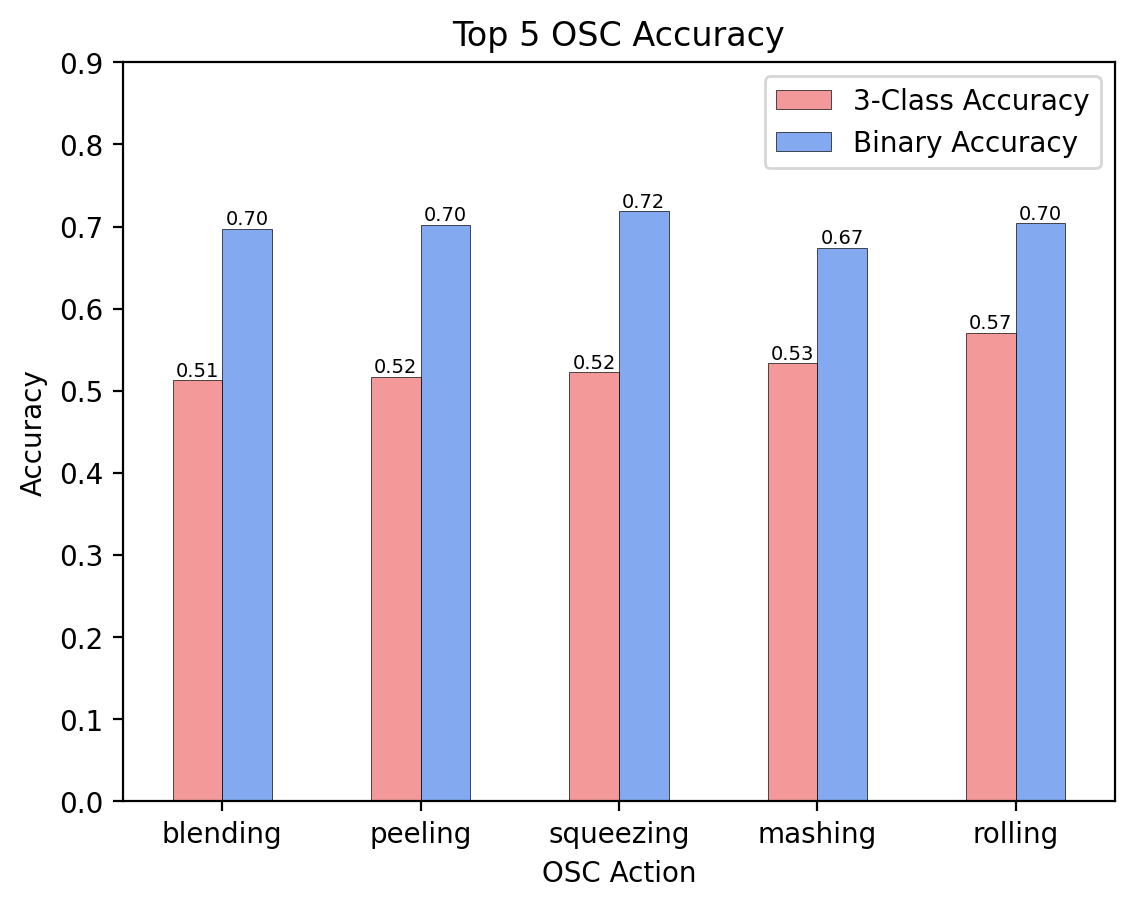

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(9, 5))

top5_accuracy = df_accuracy[-5:]
ax = top5_accuracy.plot(x='verb', y=['accuracy_all', 'accuracy_2'], kind='bar',
                 color=['lightcoral', 'cornflowerblue'], edgecolor='black', linewidth=0.3, alpha=0.8)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='edge', fontsize=7)

plt.xlabel("OSC Action")
plt.xticks(rotation=0)
plt.ylabel("Accuracy")
plt.ylim(0, 0.9)
plt.title("Top 5 OSC Accuracy")
plt.legend(["3-Class Accuracy", "Binary Accuracy"])

plt.savefig("top5_osc_accuracies.pdf")
plt.show()

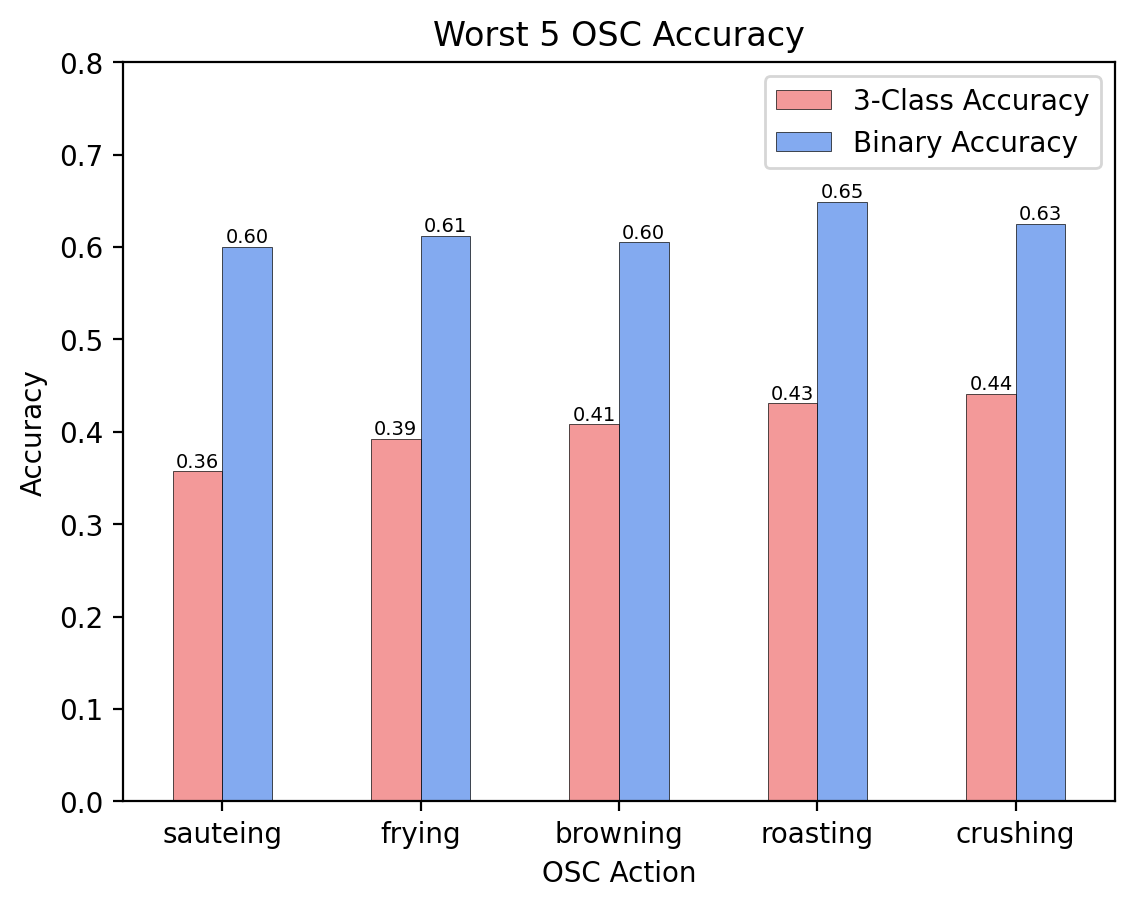

In [ ]:
worst5_accuracy = df_accuracy[:5]
ax = worst5_accuracy.plot(x='verb', y=['accuracy_all', 'accuracy_2'], kind='bar',
                 color=['lightcoral', 'cornflowerblue'], edgecolor='black', linewidth=0.3, alpha=0.8)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='edge', fontsize=7)

plt.xlabel("OSC Action")
plt.xticks(rotation=0)
plt.ylabel("Accuracy")
plt.ylim(0, 0.8)
plt.title("Worst 5 OSC Accuracy")
plt.legend(["3-Class Accuracy", "Binary Accuracy"])

plt.savefig("worst5_osc_accuracies.pdf")
plt.show()

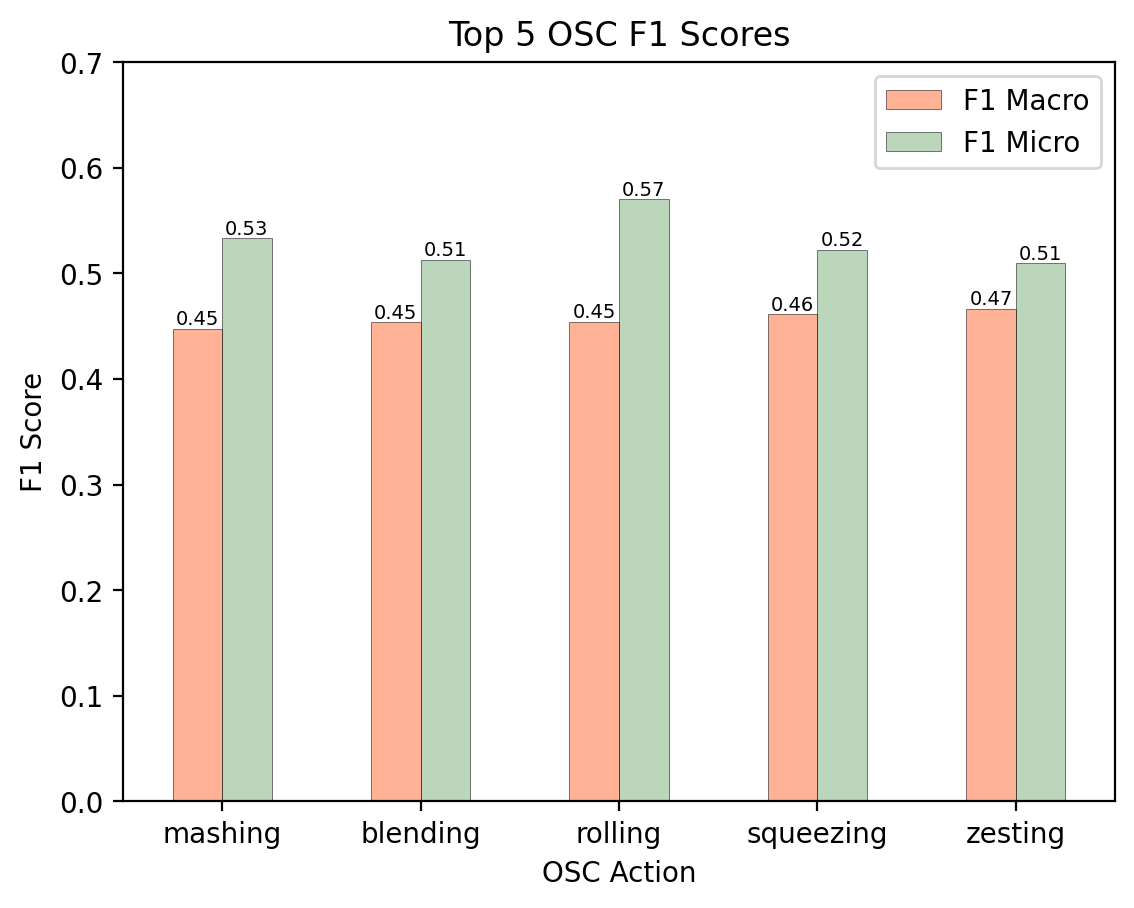

In [ ]:
top5_f1 = df_f1[-5:]
ax = top5_f1.plot(x='verb', y=['f1_macro', 'f1_micro'], kind='bar',
                 color=['coral', 'darkseagreen'], edgecolor='black', linewidth=0.3, alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='edge', fontsize=7)

plt.xlabel("OSC Action")
plt.xticks(rotation=0)
plt.ylabel("F1 Score")
plt.ylim(0, 0.7)
plt.title("Top 5 OSC F1 Scores")
plt.legend(["F1 Macro", "F1 Micro"])
plt.show()

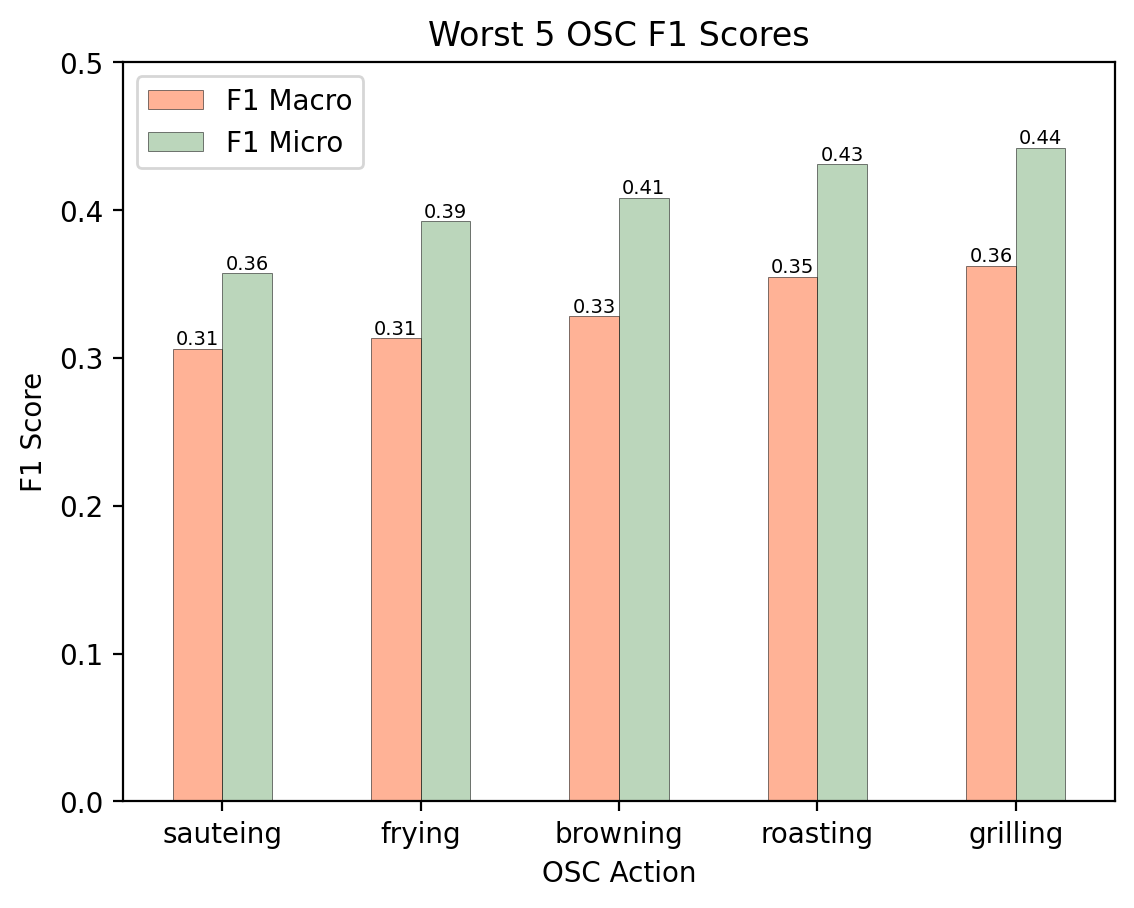

In [ ]:
worst5_f1 = df_f1[:5]
ax = worst5_f1.plot(x='verb', y=['f1_macro', 'f1_micro'], kind='bar',
                 color=['coral', 'darkseagreen'], edgecolor='black', linewidth=0.3, alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='edge', fontsize=7)

plt.xlabel("OSC Action")
plt.xticks(rotation=0)
plt.ylabel("F1 Score")
plt.ylim(0, 0.5)
plt.title("Worst 5 OSC F1 Scores")
plt.legend(["F1 Macro", "F1 Micro"])
plt.show()